## EO Data Extraction Workflow
This notebook demonstrates a streamlined workflow for extracting and processing Earth Observation (EO) data 
using the **openEO** Python client. 

### Key Steps:
1. Load and align input data (shapefile).
2. Transform GeoDataFrame for MultiBackendJobManager
3. Run the extraction process using openEO backends.
4. View and analyze the outputs (e.g., NetCDF files).

### Required Libraries:
- `openeo` for interacting with EO backends.
- `openeo-gfmap` for handling geospatial data.

### Step 1: load in the shapefile

In [ ]:
import os
import zipfile
import eotdl
from eotdl.datasets import download_dataset

download_dataset("EuroCrops", version=1, path="data", force=True)

os.makedirs("data/EuroCrops", exist_ok=True)

with zipfile.ZipFile("./data/EuroCrops/v1/EuroCrops.zip", 'r') as zip_ref:
    zip_ref.extractall("data/EuroCrops")


c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\eotdl_openeo_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 7.91G/7.91G [18:58<00:00, 7.46MiB/s]
100%|██████████| 1/1 [18:58<00:00, 1138.85s/file]


## Extract the desired geodataframe

In [1]:
import geopandas as gpd

# Define the file path
file_path = r"C:\Git_projects\eotdl\tutorials\notebooks\openeo\data\EuroCrops\BE_VLG_2021\BE_VLG_2021_EC21.shp"

# Load the shapefile
gdf = gpd.read_file(file_path)


## Subset the dataset for testing purposes

In [2]:
gdf = gdf[0:10]
gdf

,fid,GRAF_OPP,REF_ID,GWSCOD_V,GWSNAM_V,GWSCOD_H,GWSNAM_H,GWSGRP_H,GWSGRPH_LB,GWSCOD_N,...,PRC_NIS,X_REF,Y_REF,WGS84_LG,WGS84_BG,EC_NUTS3,EC_trans_n,EC_hcat_n,EC_hcat_c,geometry
0,56.0,1.0038,2.195943e+09,None,None,898,Permacultuur,Andere subsidiabele gewassen groenten - gebrui...,Overige gewassen,None,...,31033,59203.23,191139.13,"3°4'28""","51°1'24""",BE251,permaculture,permanent_crops_perennial,3303000000,"POLYGON ((59139.6 191171.57, 59230.75 191204.2..."
1,72.0,1.7600,2.192143e+09,None,None,898,Permacultuur,Andere subsidiabele gewassen groenten - gebrui...,Overige gewassen,None,...,31040,66180.66,206540.11,"3°10'13""","51°9'46""",BE251,permaculture,permanent_crops_perennial,3303000000,"POLYGON ((66098.5 206582.75, 66141.25 206653.7..."
2,87.0,0.9844,2.077538e+09,None,None,8,Volkstuinpark,None,Overige gewassen,None,...,31005,68503.64,222895.71,"3°11'59""","51°18'36""",BE251,People garden park,not_known_and_other,3399000000,"POLYGON ((68451.17 222959.44, 68445.16 222966...."
3,110.0,0.0418,2.197113e+09,None,None,8,Volkstuinpark,None,Overige gewassen,None,...,31042,60749.72,214797.48,"3°5'26""","51°14'10""",BE251,People garden park,not_known_and_other,3399000000,"POLYGON ((60736.35 214800.35, 60753.1 214812.4..."
4,193.0,0.0828,1.963867e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31033,60481.10,196996.21,"3°5'28""","51°4'34""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((60447.13 197005.27, 60513.69 196999...."
5,194.0,0.1933,1.646719e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31033,60407.66,196983.99,"3°5'25""","51°4'33""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((60454.58 196967.75, 60403.5 196971.5..."
6,197.0,0.3790,1.209108e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31033,59034.46,197810.10,"3°4'13""","51°4'59""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((59008.35 197836.92, 59020.92 197852...."
7,251.0,0.4778,1.123693e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31003,77111.23,200940.57,"3°19'40""","51°6'50""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((77081.5 200983, 77146.5 200970.5, 77..."
8,291.0,0.1857,2.077027e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31005,70905.84,219152.52,"3°14'6""","51°16'36""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((70887.36 219151.24, 70885.81 219150...."
9,292.0,0.0806,1.215109e+09,None,None,81,Braakliggend land zonder minimale activiteit,None,Overige gewassen,None,...,31005,70965.82,219106.61,"3°14'10""","51°16'35""",BE251,Derelict land with no minimum activity,unmaintained,3308000000,"POLYGON ((70957.87 219098.03, 70949.31 219117...."


# Transform GeoDataFrame for MultiBackendJobManager

This function processes an input GeoDataFrame and prepares it for use with openEO's **MultiBackendJobManager**. The job manager enables launching and tracking multiple openEO jobs simultaneously, which is essential for large-scale data extractions. 

### Example Use Case
The function creates patches (e.g., 64x64 pixels) around polygon centers. These patches are suitable for machine learning applications, such as training convolutional neural networks (CNNs).  
By combining patches into Sentinel-2 grid collections, the workflow ensures cost efficiency and optimized data extraction.

### Workflow

1. **Process the GeoDataFrame**  
   - Create patches with a fixed size around the center of polygon geometries.  
   - Calculate temporal extents for each geometry.  

2. **Combine Features Using Sentinel-2 Tiling**  
   - Group buffered geometries into collections based on the Sentinel-2 tiling grid.  
   - Minimize redundant openEO cost.  

3. **Generate Job Metadata DataFrame**  
   - Convert processed data into a DataFrame, ready for the MultiBackendJobManager.

### Parameters

#### Spatial Parameters:
- **Buffer Distance:** Buffer size (e.g., 320 meters for a 64x64 patch around polygon centers).  
- **Resolution:** Spatial alignment resolution in meters.

#### Temporal Parameters:
- **Start Date:** Start of the temporal extent (e.g., `"2020-01-01"`).  
- **Number of Months:** Duration of the temporal extent in months.

#### Job Splitting Parameters:
- **Max Points Per Job:** Maximum number of features per job batch.


In [8]:
from dataframe_utils import *

# Constants
start_date = "2020-01-01"
nb_months = 3

pixel_size = 64  # Buffer distance in meters
resolution = 10

max_points = 5

job_df = process_and_create_jobs(
    gdf, start_date, nb_months, pixel_size, resolution, max_points=max_points)

job_df

c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:80: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["centroid"] = polygons.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  s2_grid["geometry"] = s2_grid.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.

,temporal_extent,geometry,s2_tile,h3index,crs,feature_count
0,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",31UES,83194dfffffffff,EPSG:32631,5
1,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",31UES,83194dfffffffff,EPSG:32631,5


In [4]:
job_df.iloc[0]['geometry']

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"fid": 56.0, "crs": "EPSG:32631", "temporal_extent": ["2020-01-01", "2020-04-01"], "h3index": "83194dfffffffff", "tile": "31UES"}, "geometry": {"type": "Polygon", "coordinates": [[[505550.0, 5652740.0], [505550.0, 5652099.999999999], [504910.0, 5652100.0], [504909.99999999994, 5652740.0], [505550.0, 5652740.0]]]}}, {"id": "1", "type": "Feature", "properties": {"fid": 72.0, "crs": "EPSG:32631", "temporal_extent": ["2020-01-01", "2020-04-01"], "h3index": "83194dfffffffff", "tile": "31UES"}, "geometry": {"type": "Polygon", "coordinates": [[[512240.0, 5668259.999999999], [512239.99999999994, 5667619.999999997], [511600.0, 5667619.999999997], [511600.0, 5668260.0], [512240.0, 5668259.999999999]]]}}, {"id": "2", "type": "Feature", "properties": {"fid": 87.0, "crs": "EPSG:32631", "temporal_extent": ["2020-01-01", "2020-04-01"], "h3index": "83194dfffffffff", "tile": "31UES"}, "geometry": {"type": "Polygon

# Start Job with Standardized UDPs and Feature Collection Filtering

This function initializes an openEO batch job using standardized **User-Defined Processes (UDPs)** for Sentinel-1 and Sentinel-2 data processing. It employs a spatial filter designed for non-lat/lon feature collections to ensure precise patch sizes in UTM coordinates.

### Key Features

1. **Use of Standardized UDPs**  
   - **S1 Weekly Statistics:** Computes weekly statistics from Sentinel-1 data.  
   - **S2 Weekly Statistics:** Computes weekly statistics from Sentinel-2 data.  
   - UDPs are defined in external JSON files.

2. **Spatial Filtering with `load_url`**  
   - Accepts feature collections in **UTM coordinates** to guarantee patches with exact dimensions (e.g., 64x64 meters).  
   - Features are uploaded as a GeoParquet file to an creodias S3 bucket, enabling spatial filtering directly on the server.

3. **Cube Merging**  
   - Merges Sentinel-1 and Sentinel-2 datacubes for combined analysis.

4. **Job Configuration**  
   - Saves each feature in the collection as a separate file.  
   - Outputs results in **NetCDF** format with filenames derived

In [9]:
import geojson
import openeo
from s3proxy_utils import upload_geoparquet_file

def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:

        temporal_extent = eval(row["temporal_extent"])
        crs = row['crs']

        # set up load url in order to allow non-latlon feature collections for spatial filtering
        geometry = geojson.loads(row["geometry"])
        features = gpd.GeoDataFrame.from_features(geometry).set_crs(crs)
        url = upload_geoparquet_file(features,connection)

        #run the s1 and s2 udp
        s1 = connection.datacube_from_process(
                "s1_weekly_statistics",
                namespace="https://raw.githubusercontent.com/earthpulse/eotdl/refs/heads/hv_openeoexample/tutorials/notebooks/openeo/s1_weekly_statistics.json",
                temporal_extent=temporal_extent,
                )
        
        s2 = connection.datacube_from_process(
                "s2_weekly_statistics",
                namespace="https://raw.githubusercontent.com/earthpulse/eotdl/refs/heads/hv_openeoexample/tutorials/notebooks/openeo/s2_weekly_statistics.json",
                temporal_extent=temporal_extent,
                )
        
        #merge both cubes and filter across the feature collection
        merged = s2.merge_cubes(s1)
        result = merged.filter_spatial(connection.load_url(url, format="Parquet"))
        
        #dedicated job settings to save the individual features within a collection seperately
        job = result.create_job(
                out_format="NetCDF",
                sample_by_feature = True,
                feature_id_property="id",
                filename_prefix = "eotdl_"
        )

        return job

### Submit Extraction Jobs

Using the openEO backend, we authenticate and submit the jobs to process the EO data. 
Each job extracts Sentinel 1 and Sentinel 2 training features.

In [ ]:
import openeo
from openeo.extra.job_management import MultiBackendJobManager, CsvJobDatabase

# Authenticate and add the backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

# initialize the job manager
manager = MultiBackendJobManager()
manager.add_backend("cdse", connection=connection, parallel_jobs=2)

job_tracker = 'jobs.csv'
job_db = CsvJobDatabase(path=job_tracker)
if not job_db.exists():
    df = manager._normalize_df(job_df)
    job_db.persist(df)

manager.run_jobs(start_job=start_job, job_db=job_db)


Authenticated using refresh token.


Size (pixels):
Width: 1865, Height: 2299
Spatial extent:
BoundingBox(left=504620.0, bottom=5657970.0, right=523270.0, top=5680960.0)
Resolution:
(10.0, 10.0)


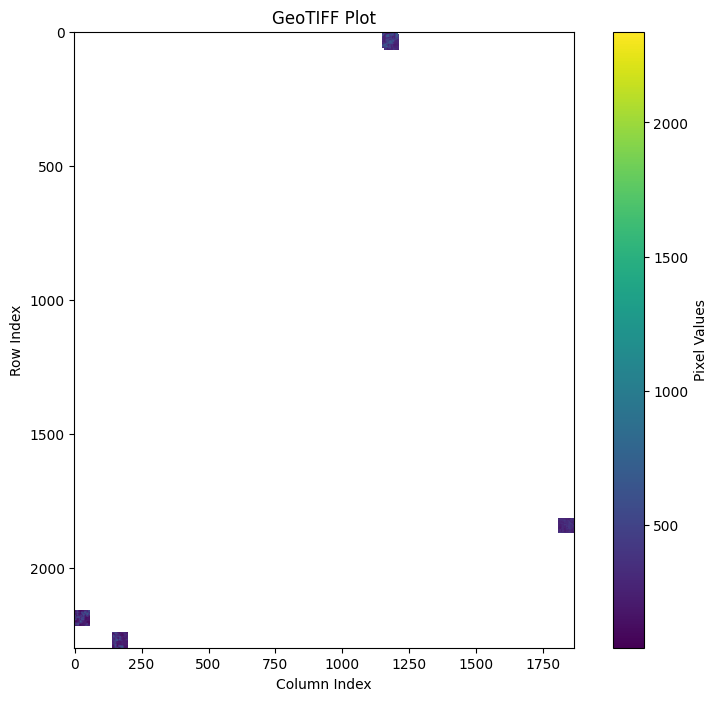

In [15]:
import rasterio
import matplotlib.pyplot as plt

# File path to the GeoTIFF file
file_path = "job_j-2412046c5be046ca94f3e1ea10c97687\eotdl.tif"

# Open the GeoTIFF file
with rasterio.open(file_path) as dataset:
    # Read the first band
    band1 = dataset.read(1)
    
    # Get metadata
    width = dataset.width  # Number of columns (pixels)
    height = dataset.height  # Number of rows (pixels)
    bounds = dataset.bounds  # Spatial extent (bounding box)
    resolution = dataset.res  # Pixel resolution (size of each pixel)
    
    print("Size (pixels):")
    print(f"Width: {width}, Height: {height}")
    print("Spatial extent:")
    print(f"{bounds}")
    print("Resolution:")
    print(f"{resolution}")
    
    # Plot the GeoTIFF
    plt.figure(figsize=(10, 8))
    plt.imshow(band1, cmap="viridis")
    plt.colorbar(label="Pixel Values")
    plt.title("GeoTIFF Plot")
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.show()

Step 4: We run the various openEO Jobs. Note all data will be locally downloaded as netcdfs named after the file_name property within the individual features (see process_file)

TODO;
1) simplified example. (non cost efficient)
--> point extraction (parcel averaged)
2) integrate with eotdl example
3) export workspace
4) advanced patch extraction
5) signed URL